### Import and Configuration:

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

random.seed(149)

In [2]:
def loaddata():
    return pd.read_csv('food_coded.csv')
data = loaddata()

## Preprocessing:

#### Employment:

In [3]:
# employment, sample from prob dist and fill the missing values
probibility = data['employment'].value_counts() / data['employment'].value_counts().sum().tolist()
count_of_nas = pd.isna(data['employment']).sum()
values = probibility.cumsum().searchsorted(np.random.uniform(size=count_of_nas))
for i in xrange(len(values)):
    if values[i] == 0: values[i] = 2
    elif values[i] == 1: values[i] = 3
    else: values[i] = 1
index = 0
for i in xrange(len(data.employment)):
    if pd.isnull(data.iloc[i].employment):
        data.loc[i, 'employment'] = values[index]
        index += 1

#### Sports:

We took a look on the students' answers and compiled a list of their sports, then replaced their text answers with a comma seperated list of the sports they played. Morever, we replaced any other answers like "I don't play sports" and "not really" with an NA

In [4]:
sports = ['car racing', 'basketball', 'softball', 'soccer', 'field hockey', 'running', 'volleyball', 'hockey', \
          'dancing', 'tennis', 'gym', 'football', 'lacrosse', 'snowboarding', 'wrestling', 'rowing', 'skiing', \
          'water polo', 'baseball', 'horse back riding', 'golf']
sports.sort(key=len, reverse=True)
print data.type_sports.value_counts().sample(frac=1).head(15)
def func(x):
    output = ''
    for sport in sports:
        if pd.isnull(x): continue
        x = x.lower()
        if x.find(sport) != -1:
            output += sport + ','
            x.replace(sport, '')
    if len(output) == 0: return np.NaN
    return output[:-1]
data.type_sports = data.type_sports.apply(func=func)

print "\n\nAfter Processing:\n", data.type_sports.value_counts().head(15)

horse back riding                           1
None                                        5
Basketball                                  2
Ice hockey                                  2
Tennis, Basketball                          1
None at the moment                          1
Recreational Basketball, Equestrian Team    1
Skiing                                      1
soccer                                      1
Soccer                                      4
 None                                       1
Volleyball, Track                           1
rowing                                      1
Softball                                    3
Football, Basketball, Volleyball, Golf      1
Name: type_sports, dtype: int64


After Processing:
hockey                 12
softball                9
soccer                  8
volleyball              7
basketball              6
wrestling               4
lacrosse                4
tennis                  3
skiing                  3
field hockey,hockey     

## Plots:
### First descriptive statistics:

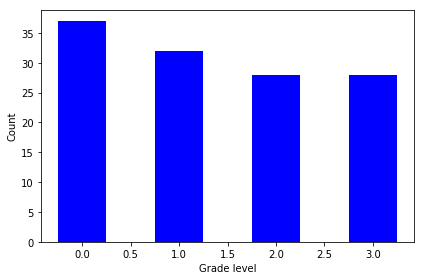

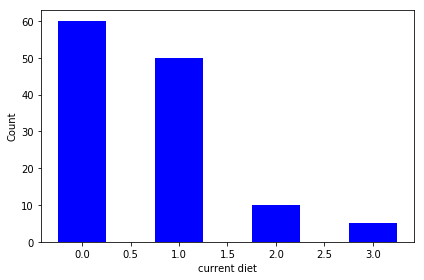

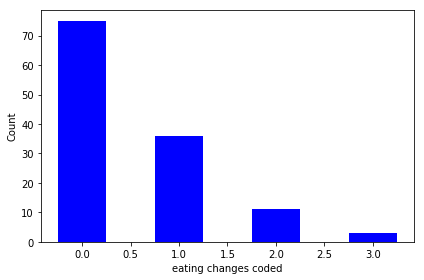

In [9]:
def bar_chart(attribute, ticks_values,label):
    y = data[attribute].value_counts()
    N = len(y)
    x = range(N)
    width = 0.5
    plt.bar(x, y, width, color="blue" )
    plt.xlabel(label)
    plt.ylabel('Count')
    index = ind = np.arange(len(x)) 
    #plt.xticks(index + width / 2, ticks_values)

    plt.tight_layout()
    plt.show()

bar_chart('grade_level',('freshman' ,'Sophomore' ,'Junior' ,'Senior'),'Grade level')
bar_chart('diet_current_coded',('healthy' ,'unhelathy' ,'same thing' ,'unclear'),'current diet')

bar_chart('eating_changes_coded',('worse' ,'better' ,'same' ,'unclear'),'eating changes coded')


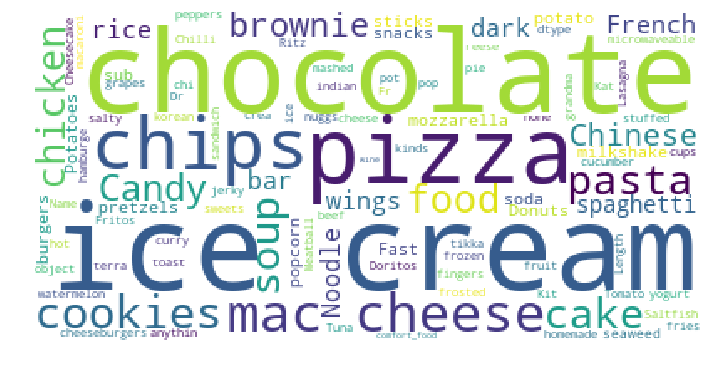

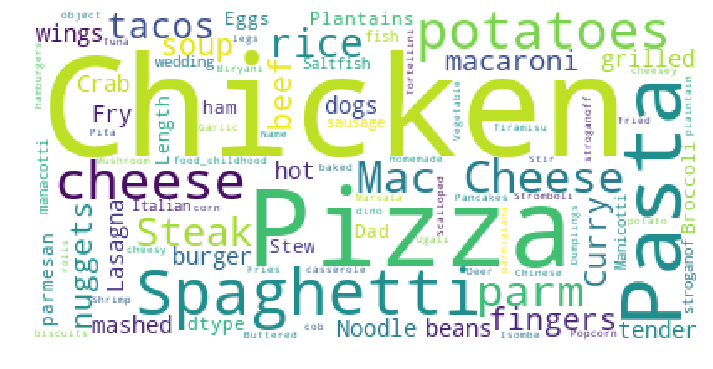

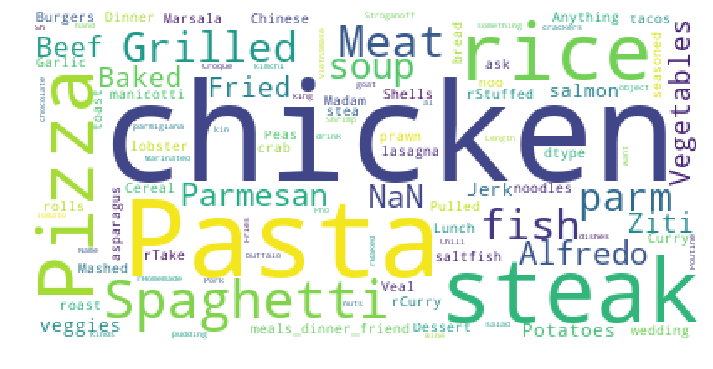

In [70]:
#todo add label to the graph ?

def word_cloud(attribute):
    wordcloud = WordCloud(background_color='white' ).generate(str(data[attribute]))
    plt.rcParams['figure.figsize'] = (12,10)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
word_cloud('comfort_food')
word_cloud('food_childhood')
word_cloud('meals_dinner_friend')

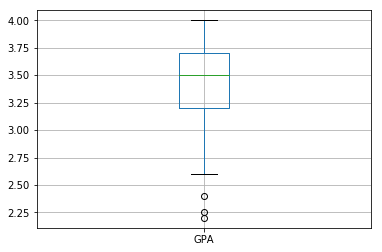

In [7]:
#not sure if important
data.boxplot('GPA')
plt.show()

In [76]:
# TODO: Remove useless columns: non-coded columns
#columns_we7sha = ["life_rewarding", "comfort_food_reasons_coded", "comfort_food_reasons"]

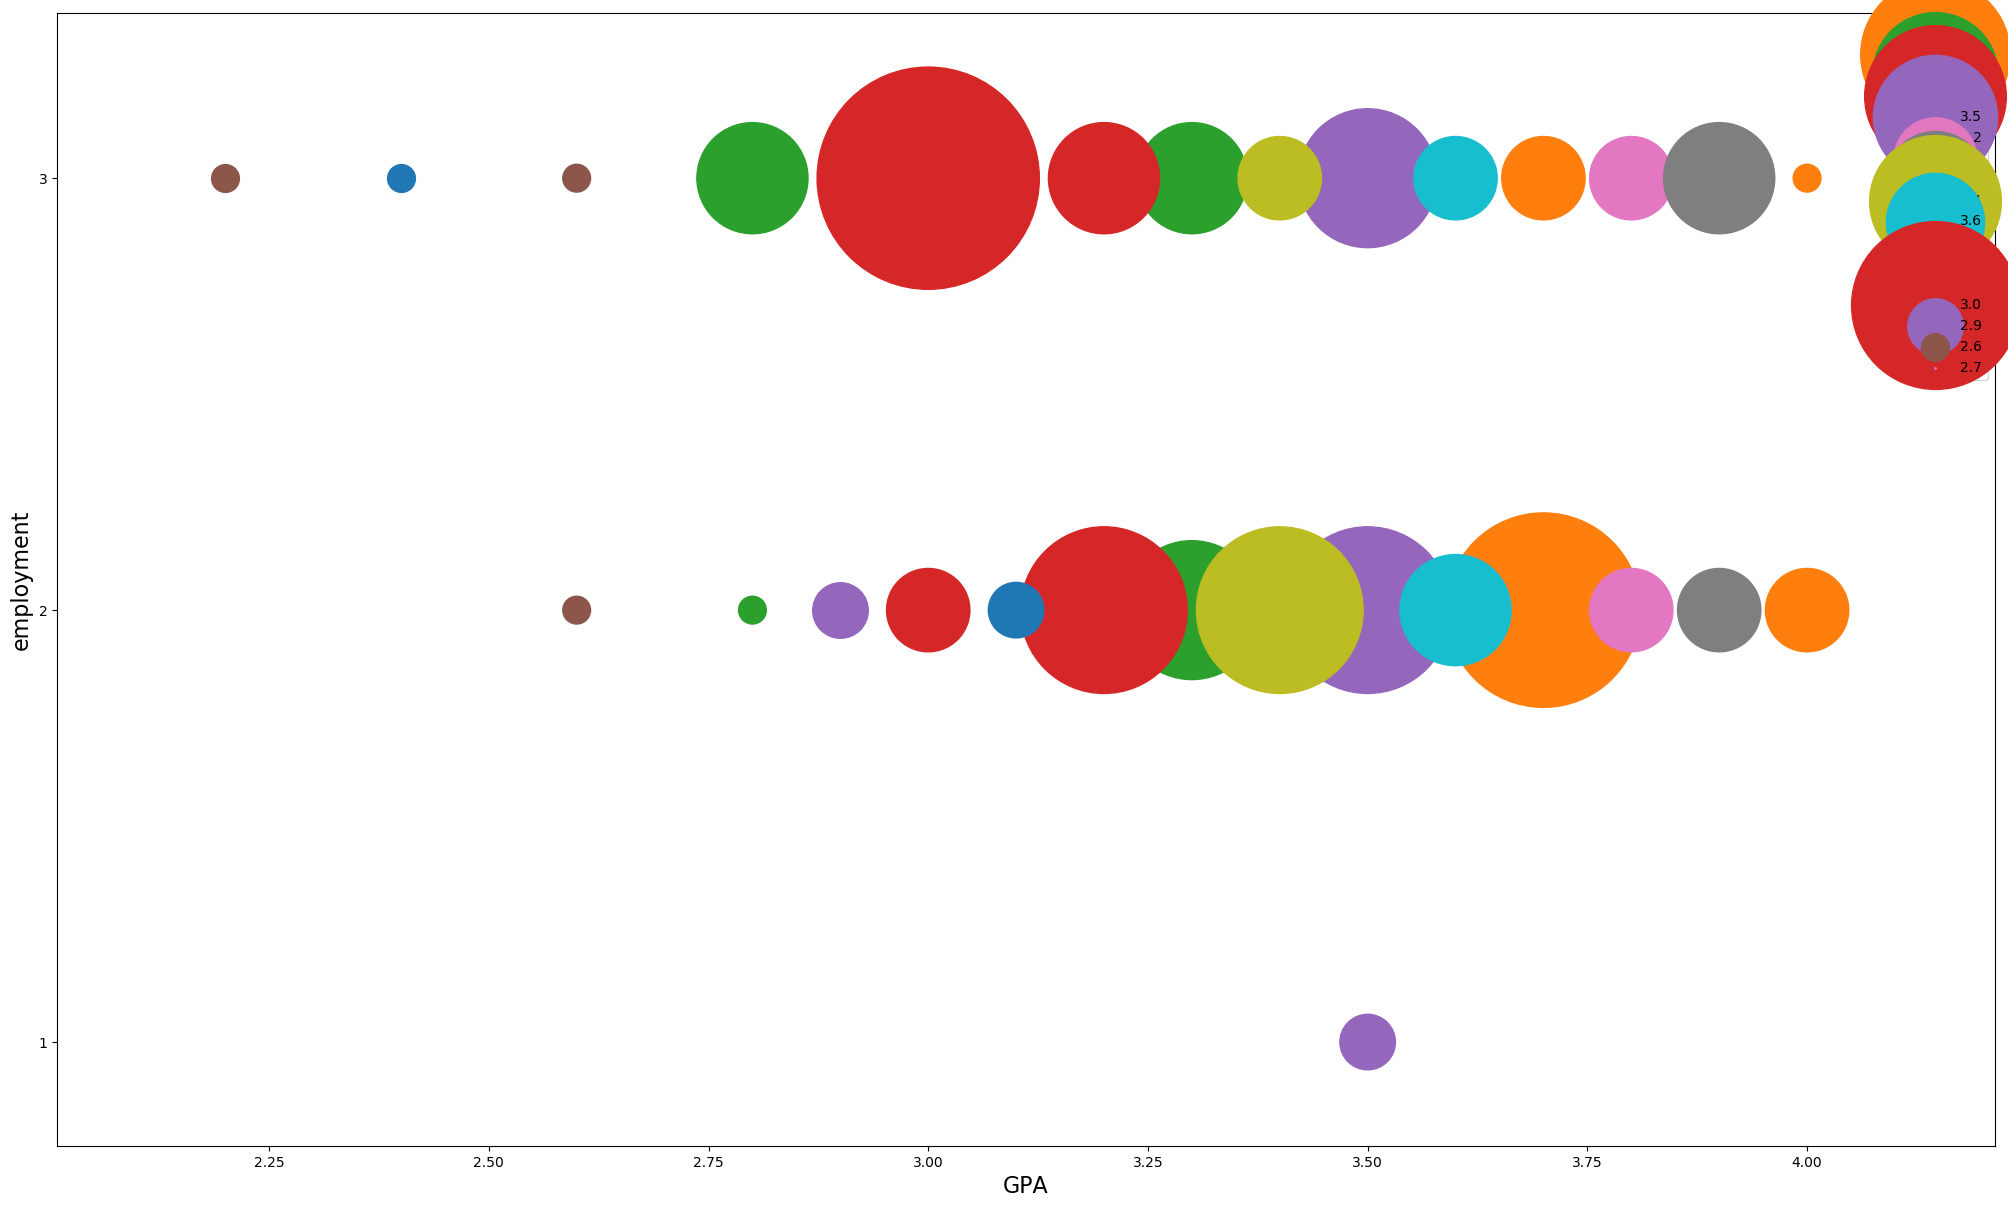

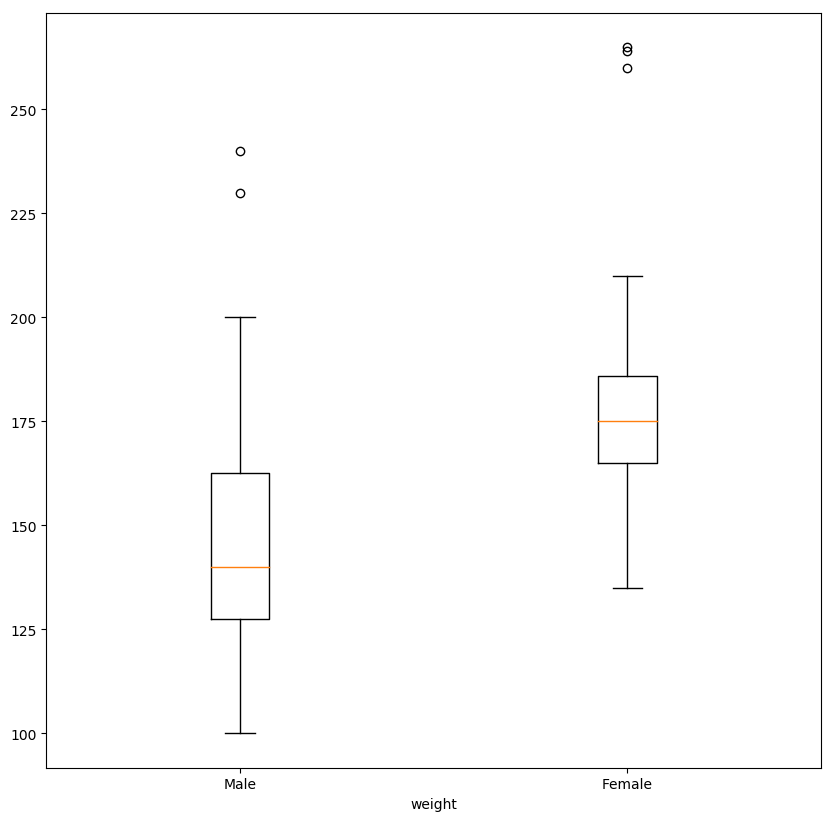

In [8]:
#data = loaddata()

#x_attribute = 'GPA'
#y_attribute = 'eating_out'

def boxplot(attribute):
    plt.figure(dpi=100, figsize=(10,10))
    plt.rc('axes', axisbelow=True)
    plt.boxplot([list(data.query('Gender==1')[attribute].dropna()), list(data.query('Gender==2')[attribute].dropna())], labels=["Male", "Female"])
    plt.rc('axes', axisbelow=True)
    plt.xlabel(attribute)
    plt.show()

def bubble_chart(x_attribute, y_attribute):    
    plt.figure(dpi=100, figsize=(25,15))
    
    x_axis = data[x_attribute].round(decimals=1).dropna().unique()
    for mark in x_axis:
        y_axis =  data.query('%s == %f' % (x_attribute, mark))[y_attribute].dropna().unique()
        s = [(20 * len(data.query('%s == %f & %s == %f' % (x_attribute, mark, y_attribute, i) ))) ** 2 for i in y_axis]
        plt.scatter([mark]*len(y_axis), y_axis, s = s)

    y_ticks = data[y_attribute].round(decimals=1).dropna().unique()
    plt.yticks(y_ticks)
    plt.ylabel(y_attribute, fontsize= 16)
    plt.xlabel(x_attribute, fontsize= 16)
    plt.margins(0.1)
    plt.legend(x_axis)
    plt.figure(dpi=40)
    plt.show()

    
#def grouped_barchart(x_attribute, y_attribute):
#    fig, ax = plt.subplots()
#    cm = 1
#    inch = 1.2
    
#    x_axis_unique = data[x_attribute].round(decimals=1).dropna().unique()
#    y_axis_unique = data[y_attribute].round(decimals=1).dropna().unique()
    
#    for x in x_axis_unique:
#        y_axis =  data.query('%s == %f' % (x_attribute, mark))[y_attribute].dropna().unique()
    
#    ind = np.arange(len(x_axis))    # the x locations for the groups
#    width = 0.35         # the width of the bars
#    p1 = ax.bar(ind, x_axis, width, color='r', bottom=0*cm, yerr=menStd)


#    womenMeans = (145*cm, 149*cm, 172*cm, 165*cm, 200*cm)
#    womenStd = (30*cm, 25*cm, 20*cm, 31*cm, 22*cm)
#    p2 = ax.bar(ind + width, womenMeans, width,
#                color='y', bottom=0*cm, yerr=womenStd)

#    ax.set_title('Scores by group and gender')
#    ax.set_xticks(ind + width / 2)
#    ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

#    ax.legend((p1[0], p2[0]), ('Men', 'Women'))
#    ax.yaxis.set_units(inch)
#    ax.figsize = (10, 10)
#    ax.autoscale_view()

#    plt.show()

#grouped_barchart()

bubble_chart('GPA', 'employment') #todo change it to smthng meaningful
boxplot('weight')

In [50]:
#print len(data.query('Gender == 1')), len(data.query('Gender == 2'))

76 49


In [104]:
#data.father_profession.unique()

array(['profesor ', 'Self employed ', 'owns business', 'Mechanic ', 'IT',
       'Taxi Driver', 'Assembler ', 'Business guy',
       'High School Principal', 'commissioner of erie county ', 'Idk',
       'Home Marker ', 'Shirt designer ', 'business owner',
       'Commidity trader ', 'Hockey Coach', 'Construction ',
       'self employed construction ', 'Engineer', 'architect', 'CFO',
       'European logistics director ', 'accountant ',
       'Commercial Real Estate', 'Manager at Pepsi', 'VP of ',
       'Beverage and Food Sales', 'Dentist ', 'Electrical Engineer',
       'Radio Telecommunications Manager', nan, 'deceased', 'Lawyer',
       'landscaping ', 'Vice President of a company',
       'Owns his own promotional company ', 'Optometrist ',
       'Biohemical Waste Elimination', 'Corporate Manager ',
       'Small business owner ', 'Welder', 'Design Engineer', 'Unknown ',
       'Banker', 'subcontractor ', 'small business owner ',
       'House Appraiser', 'not sure', 'Fireman',